In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.analysis import circular_stats
import os 

In [2]:
def get_task_variables(data:SpikeData,bhv:BhvData,in_out:str='in'):
    # Select trials (correct and DMTS task) and create task frame
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]

    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=bhv.condition[trial_idx],
        test_stimuli=bhv.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    task = task[task['in_out']==in_out]
    return task, trial_idx

In [3]:
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_bhv_lip.txt", "r")
lines_bhv = file1.readlines()
file1.close()
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_sp_lip.txt", "r")
lines_sp = file1.readlines()
file1.close()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

In [4]:
n_bhv=paths_bhv[16]
n_sp = paths_sp[16]
s_path = os.path.normpath(n_sp).split(os.sep)
b_path = os.path.normpath(n_bhv).split(os.sep)
print(n_sp)
if b_path[-1][:19] != s_path[-1][:19]:
    raise NameError

date = s_path[-1][:19]
data = SpikeData.from_python_hdf5(n_sp)
bhv = BhvData.from_python_hdf5(n_bhv)
print(data.clustersgroup)

/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2023-02-09_10-42-54_Riesling_lip_e1_r1_sp.h5
['good' 'good' 'good' 'mua']


In [173]:
np.where(np.logical_and(bhv.trial_error == 0, bhv.block == 1))[0].shape

(337,)

In [174]:
# correct and incorrect trials
trial_idx = np.where(np.logical_and(bhv.trial_error == 0, bhv.block == 1))[0]

if np.any(np.isnan(data.neuron_cond)):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond=data.neuron_cond
task = def_task.create_task_frame(
    condition=bhv.condition[trial_idx],
    test_stimuli=bhv.test_stimuli[trial_idx],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond = neuron_cond,
)
task_neuron = task[task['i_neuron']==0]
task_in = task_neuron[task_neuron['in_out']=='in']
task_out = task_neuron[task_neuron['in_out']=='out']

In [180]:
task_neuron = task[task['i_neuron']==0]
len(task_in)

190

<AxesSubplot: xlabel='sample', ylabel='Count'>

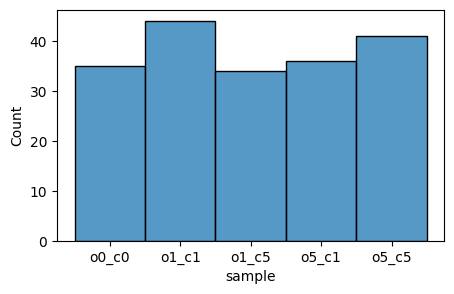

In [35]:
fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(task_in['sample'].sort_values())    

In [178]:
task_o1_c1 = task_in[task_in['sample']=='o1_c1']
task_o1_c5 = task_in[task_in['sample']=='o1_c5']
task_o5_c1 = task_in[task_in['sample']=='o5_c1']
task_o5_c5 = task_in[task_in['sample']=='o5_c5']

Text(0.5, 1.0, 'o5_c5')

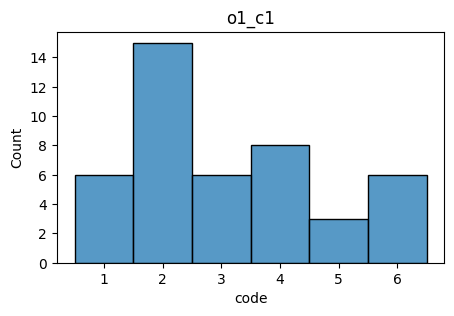

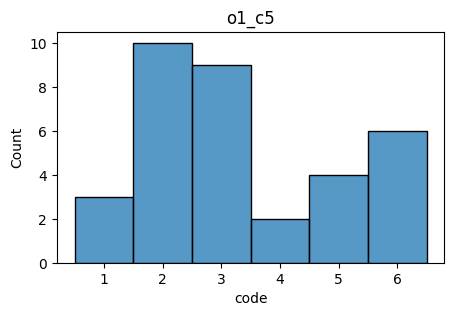

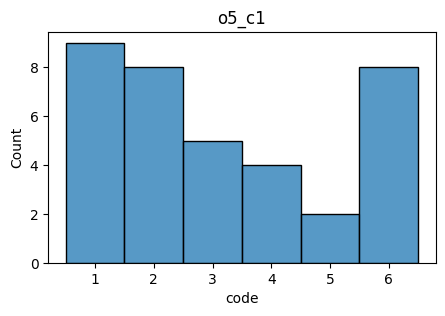

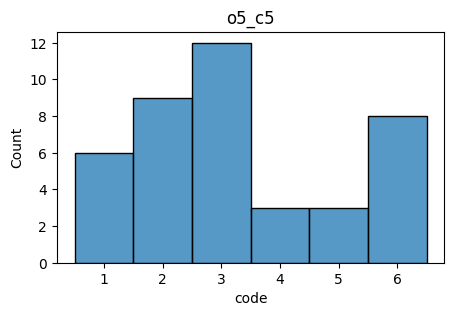

In [42]:
fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(task_o1_c1['code'].sort_values().astype(str))    
ax.set_title('o1_c1')
fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(task_o1_c5['code'].sort_values().astype(str))    
ax.set_title('o1_c5')
fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(task_o5_c1['code'].sort_values().astype(str))    
ax.set_title('o5_c1')
fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(task_o5_c5['code'].sort_values().astype(str))    
ax.set_title('o5_c5')

In [46]:
def select_trials(bhv,data,idx,i_neuron=0):
    test_stimuli = bhv.test_stimuli[idx]
    code_numbers = data.code_numbers[idx]
    code_samples = data.code_samples[idx]
    sp_samples = data.sp_samples[idx,i_neuron]
    return test_stimuli,code_numbers,code_samples,sp_samples

In [59]:
def delete_match(test_stimuli,code):
    code = (code-1).astype(int)
    tests_shape=test_stimuli.shape
    test_stimuli = np.concatenate([test_stimuli,np.ones((tests_shape[0],1))],axis=1)
    test_stimuli[np.arange(tests_shape[0]),code] =  np.nan
    test_stimuli = test_stimuli[:,:tests_shape[1]]
    return test_stimuli

In [132]:
task_o1 = pd.concat([task_o1_c1,task_o1_c5])
task_o5 = pd.concat([task_o5_c1,task_o5_c5])
task_c1 = pd.concat([task_o1_c1,task_o5_c1])
task_c5 = pd.concat([task_o5_c5,task_o1_c5])

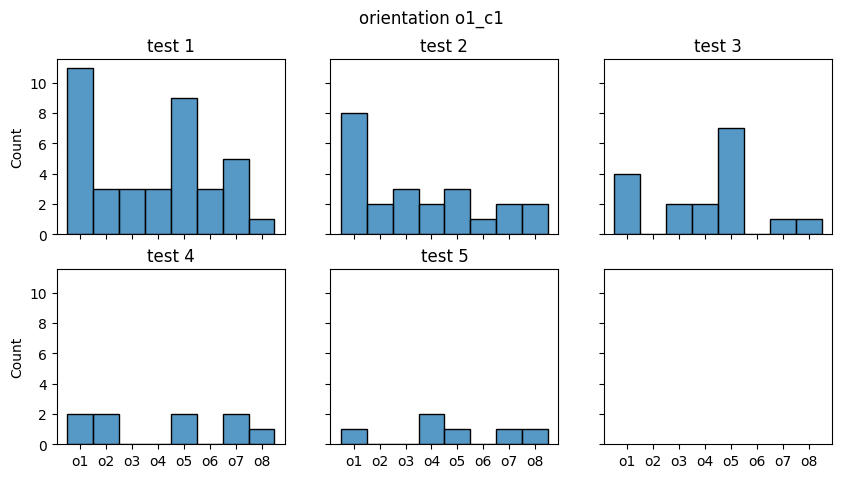

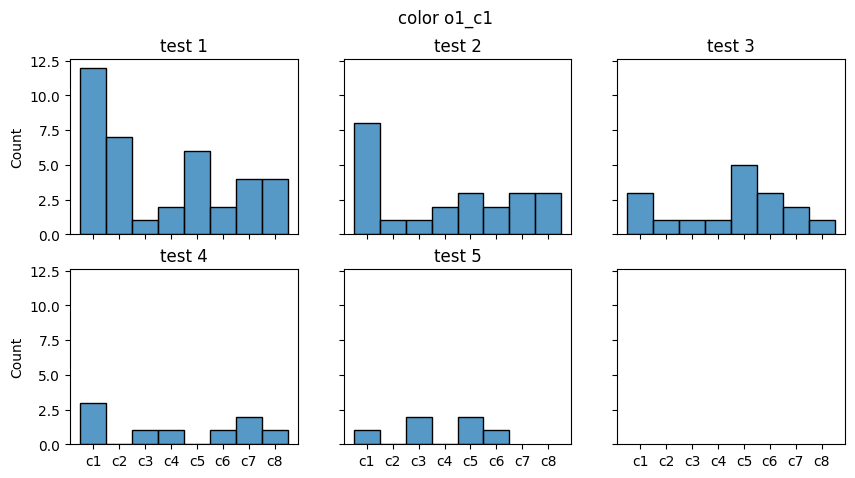

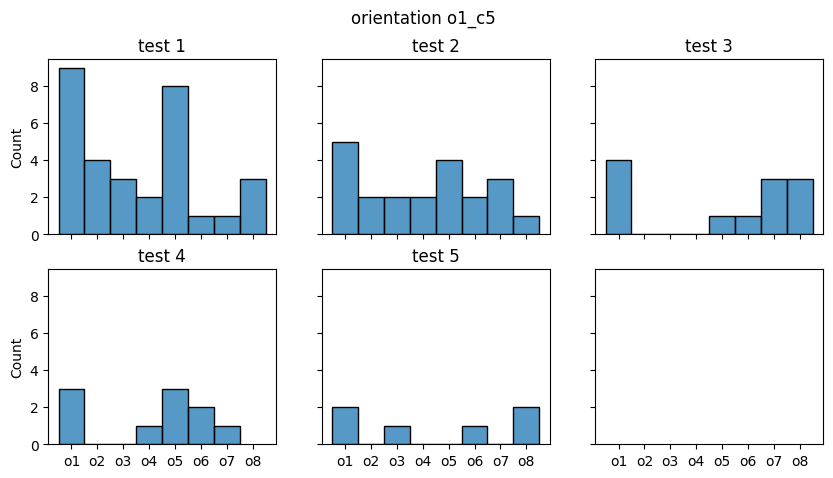

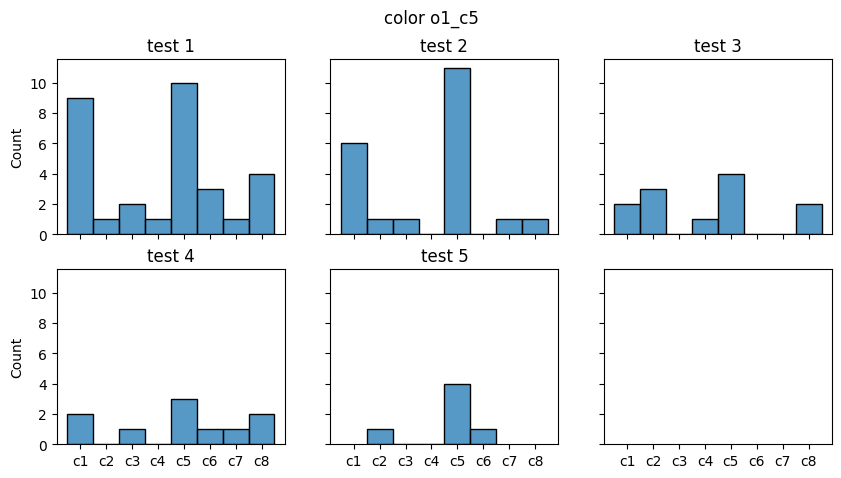

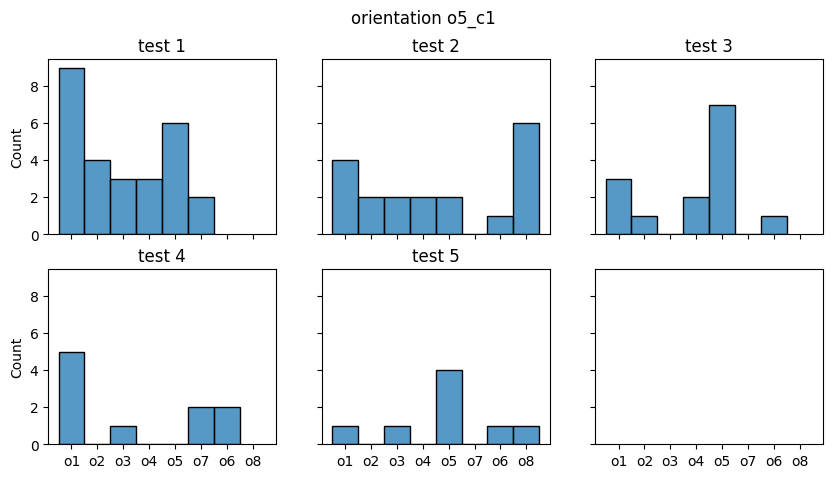

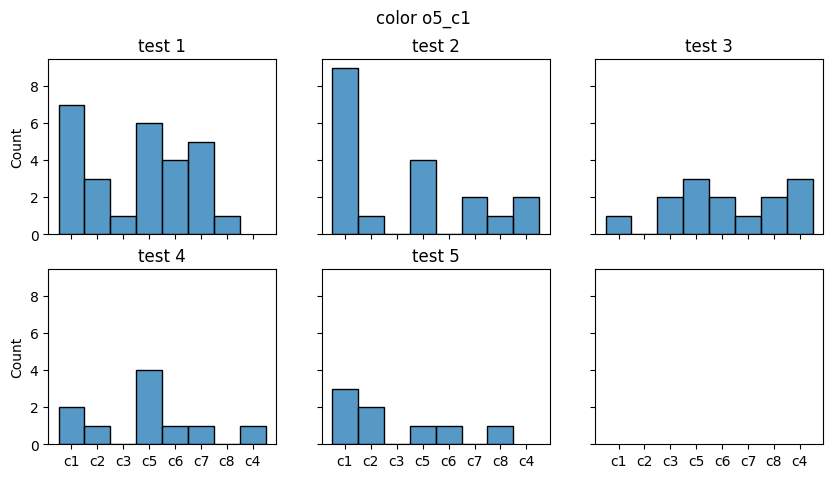

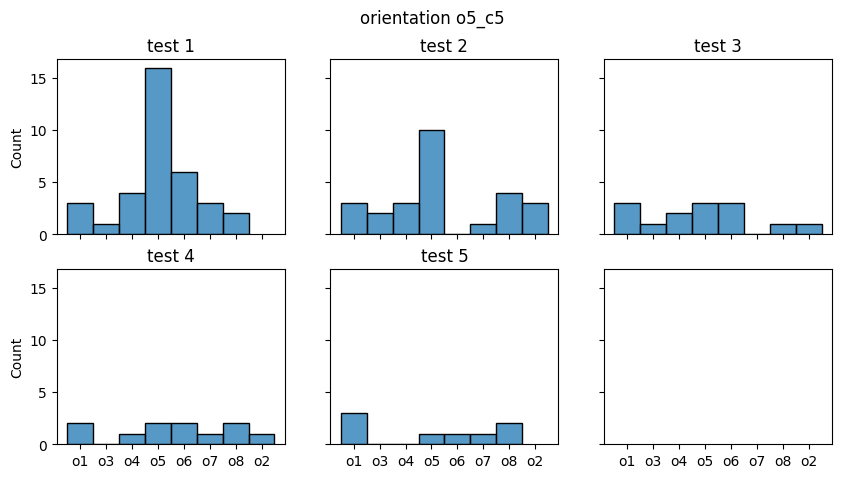

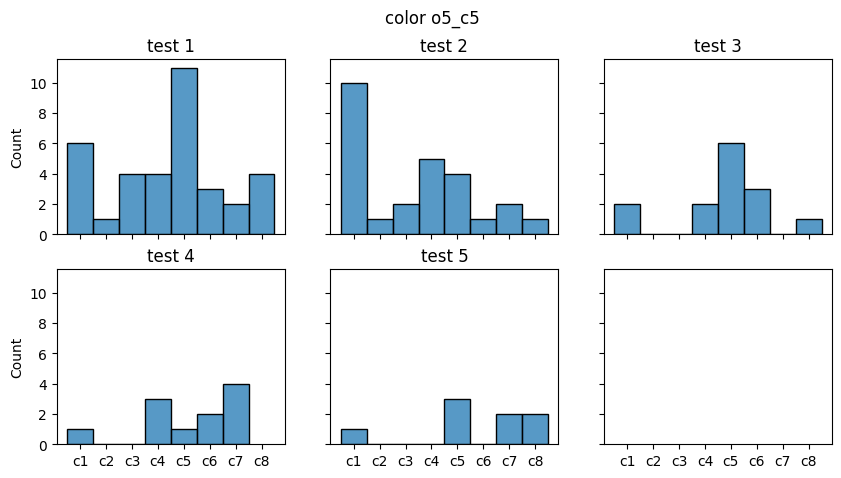

In [159]:
for task_o_c in [task_o1_c1,task_o1_c5,task_o5_c1,task_o5_c5]:
    test_stimuli,code_numbers,code_samples,sp_samples = select_trials(bhv,data,trial_idx[task_o_c['trial_idx'].values],i_neuron=0)
    code = task_o_c['code'].values
    test_stimuli_samp = delete_match(test_stimuli,code)
    # orientation
    test_stimuli_o = (test_stimuli_samp//10)
    test_o = pd.DataFrame(test_stimuli_o).replace([1,2,3,4,5,6,7,8,np.nan],['o1','o2','o3','o4','o5','o6','o7','o8','nan'])
    fig,((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(2,3,figsize=(10,5),sharex=True,sharey=True)
    ax = [ax1,ax2,ax3,ax4,ax5,ax6]
    for i in range(5):
        no_nan = np.where(test_o[i].sort_values().values!='nan')[0]
        sns.histplot(test_o[i].sort_values().values[no_nan],ax=ax[i])
        ax[i].set_title('test %d'%int(i+1))
    fig.suptitle('orientation %s'%task_o_c['sample'].values[0])
    # color
    test_stimuli_o = (test_stimuli_samp%10)
    test_o = pd.DataFrame(test_stimuli_o).replace([1,2,3,4,5,6,7,8,np.nan],['c1','c2','c3','c4','c5','c6','c7','c8','nan'])
    fig,((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(2,3,figsize=(10,5),sharex=True,sharey=True)
    ax = [ax1,ax2,ax3,ax4,ax5,ax6]
    for i in range(5):
        no_nan = np.where(test_o[i].sort_values().values!='nan')[0]
        sns.histplot(test_o[i].sort_values().values[no_nan],ax=ax[i])
        ax[i].set_title('test %d'%int(i+1))
    fig.suptitle('color %s'%task_o_c['sample'].values[0])

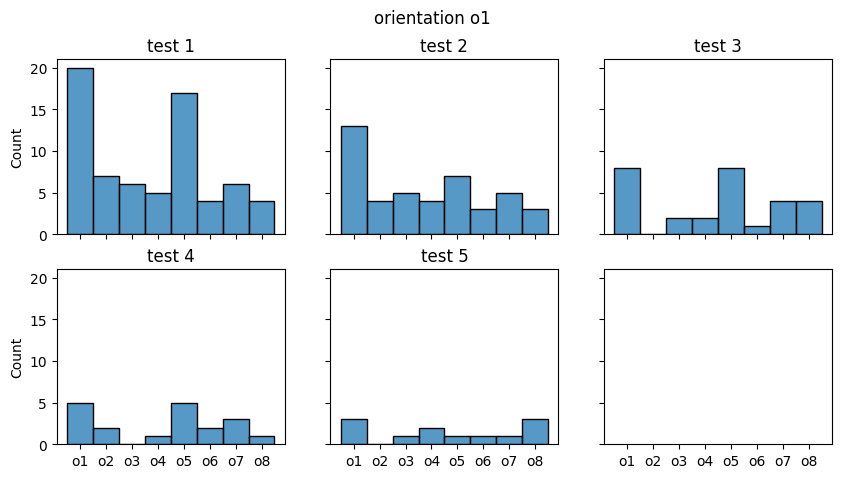

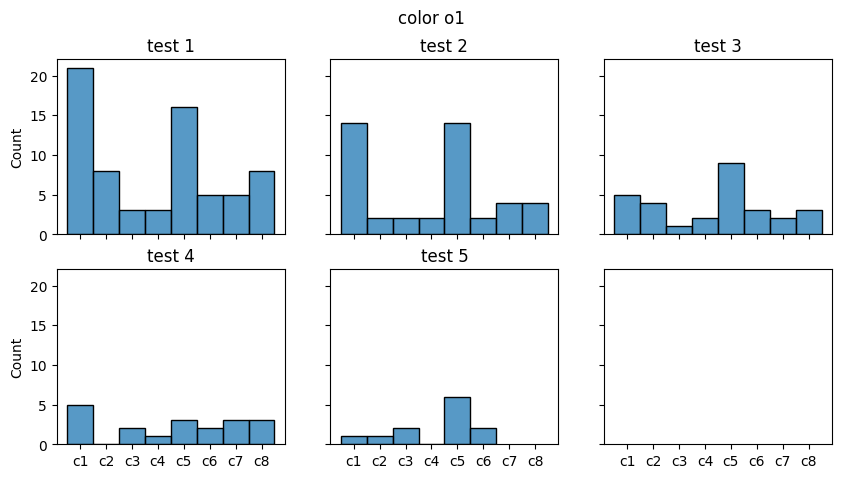

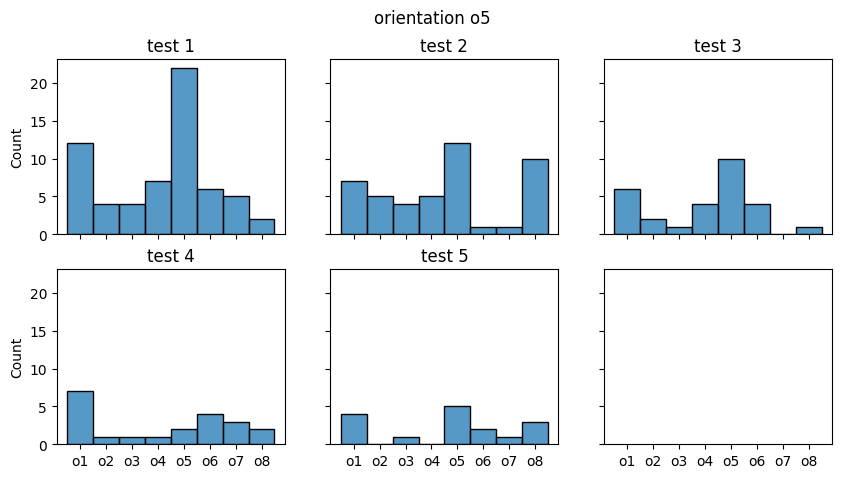

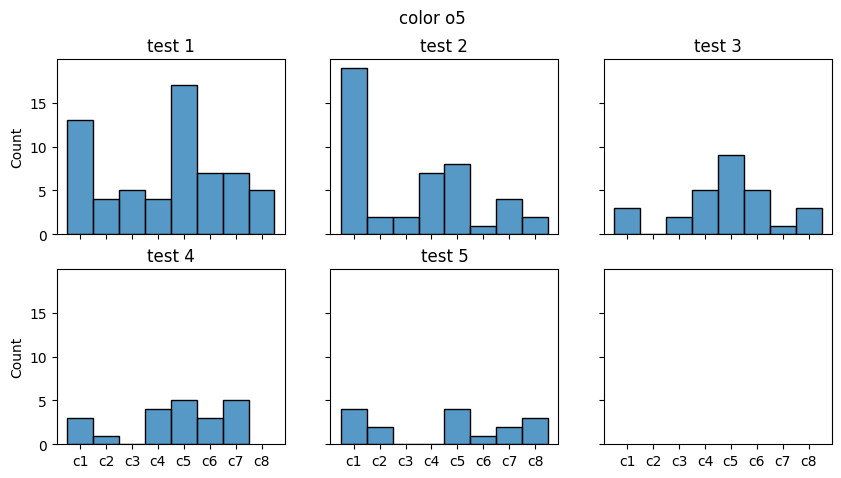

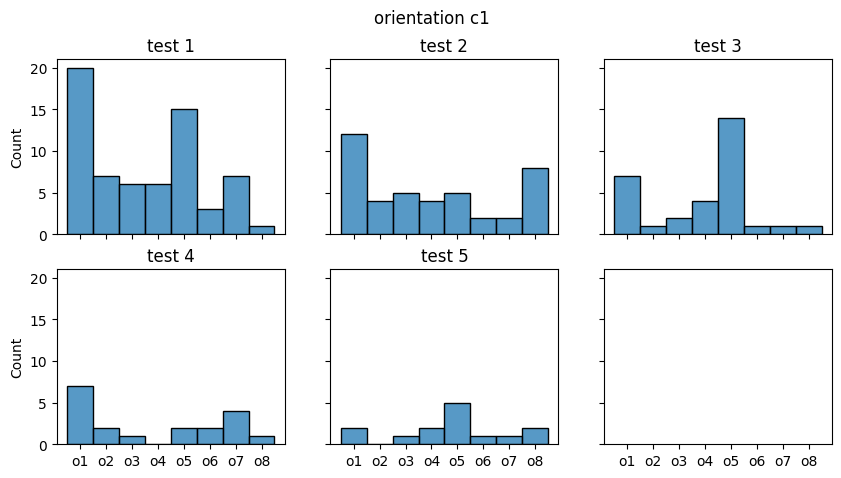

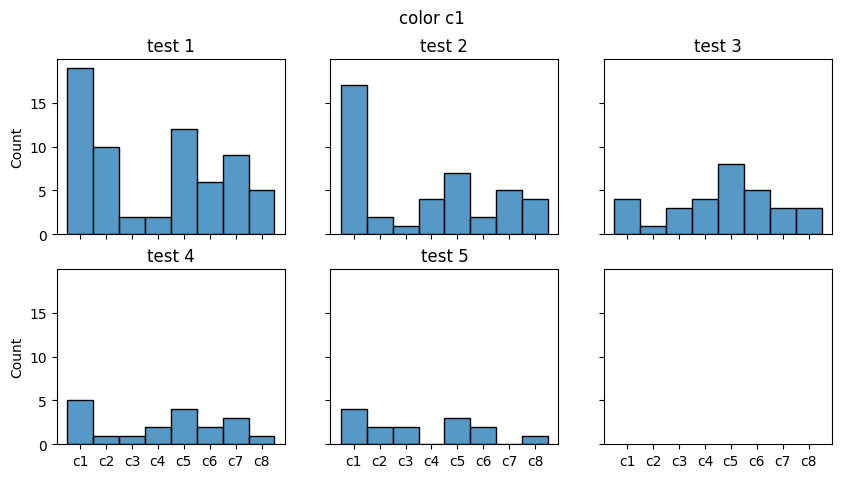

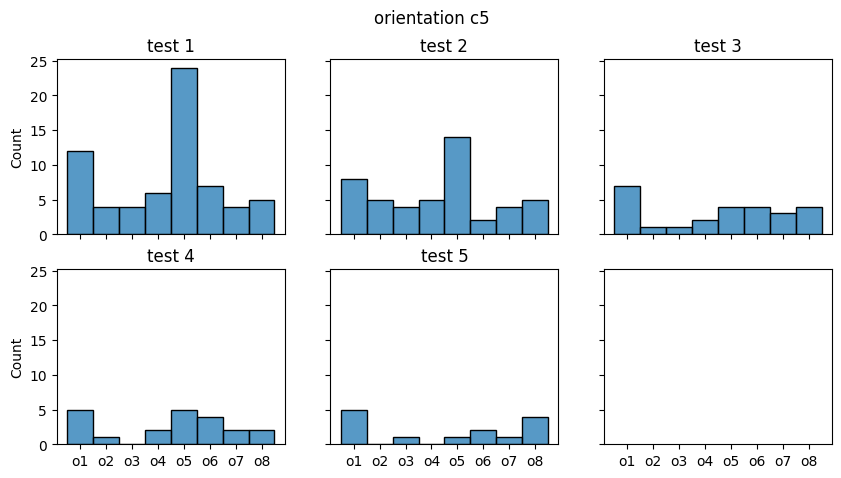

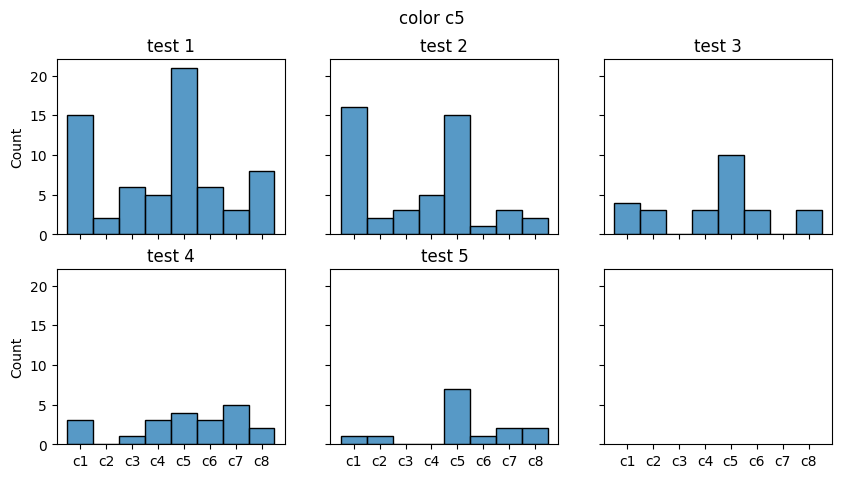

In [158]:
for task_o_c,o_c in zip([task_o1,task_o5,task_c1,task_c5],['o1','o5','c1','c5']):
    test_stimuli,code_numbers,code_samples,sp_samples = select_trials(bhv,data,trial_idx[task_o_c['trial_idx'].values],i_neuron=0)
    code = task_o_c['code'].values
    test_stimuli_samp = delete_match(test_stimuli,code)
    # orientation
    test_stimuli_o = (test_stimuli_samp//10)
    test_o = pd.DataFrame(test_stimuli_o).replace([1,2,3,4,5,6,7,8,np.nan],['o1','o2','o3','o4','o5','o6','o7','o8','nan'])
    fig,((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(2,3,figsize=(10,5),sharex=True,sharey=True)
    ax = [ax1,ax2,ax3,ax4,ax5,ax6]
    for i in range(5):
        no_nan = np.where(test_o[i].sort_values().values!='nan')[0]
        sns.histplot(test_o[i].sort_values().values[no_nan],ax=ax[i])
        ax[i].set_title('test %d'%int(i+1))
    fig.suptitle('orientation %s' %o_c)
    # code = task_o_c['code'].values
    # test_stimuli_samp = delete_match(test_stimuli,code)
    # color
    test_stimuli_o = (test_stimuli_samp%10)
    test_o = pd.DataFrame(test_stimuli_o).replace([1,2,3,4,5,6,7,8,np.nan],['c1','c2','c3','c4','c5','c6','c7','c8','nan'])
    fig,((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(2,3,figsize=(10,5),sharex=True,sharey=True)
    ax = [ax1,ax2,ax3,ax4,ax5,ax6]
    for i in range(5):
        no_nan = np.where(test_o[i].sort_values().values!='nan')[0]
        sns.histplot(test_o[i].sort_values().values[no_nan],ax=ax[i])
        ax[i].set_title('test %d'%int(i+1))
    fig.suptitle('color %s'%o_c)

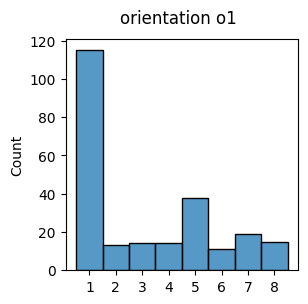

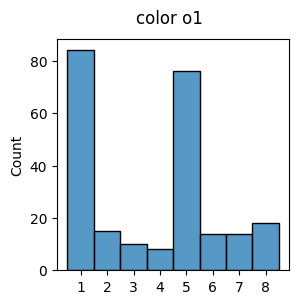

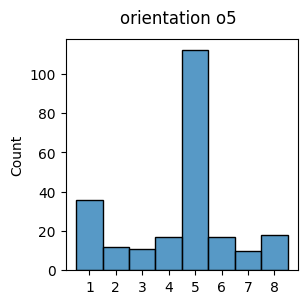

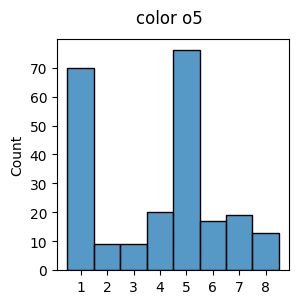

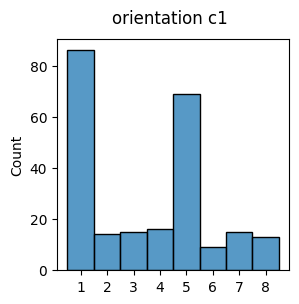

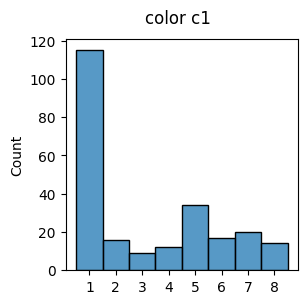

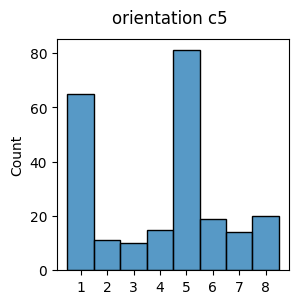

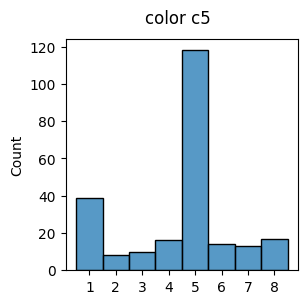

In [167]:
for task_o_c,o_c in zip([task_o1,task_o5,task_c1,task_c5],['o1','o5','c1','c5']):
    test_stimuli,code_numbers,code_samples,sp_samples = select_trials(bhv,data,trial_idx[task_o_c['trial_idx'].values],i_neuron=0)
    code = task_o_c['code'].values
    test_stimuli_samp = test_stimuli#delete_match(test_stimuli,code)
    # orientation
    test_stimuli_o = (test_stimuli_samp//10)
    # test_o = pd.DataFrame(test_stimuli_o).replace([1,2,3,4,5,6,7,8,np.nan],['o1','o2','o3','o4','o5','o6','o7','o8','nan'])
    fig,ax = plt.subplots(figsize=(3,3))
    sns.histplot(np.sort(test_stimuli_o[np.where(np.isnan(test_stimuli_o),False,True)]).astype(int).astype(str))
    fig.suptitle('orientation %s' %o_c)
    # color
    test_stimuli_o = (test_stimuli_samp%10)
    # test_o = pd.DataFrame(test_stimuli_o).replace([1,2,3,4,5,6,7,8,np.nan],['c1','c2','c3','c4','c5','c6','c7','c8','nan'])
    fig,ax = plt.subplots(figsize=(3,3))
    sns.histplot(np.sort(test_stimuli_o[np.where(np.isnan(test_stimuli_o),False,True)]).astype(int).astype(str))
    fig.suptitle('color %s'%o_c)

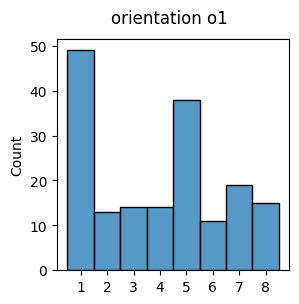

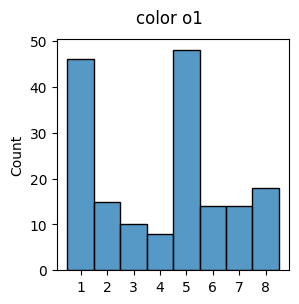

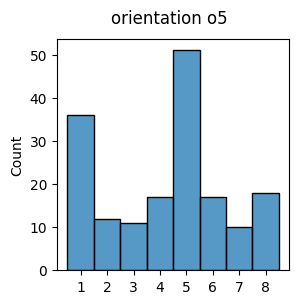

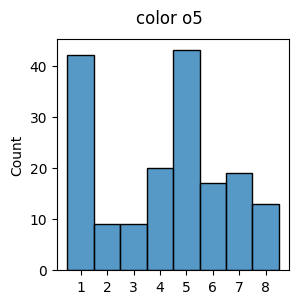

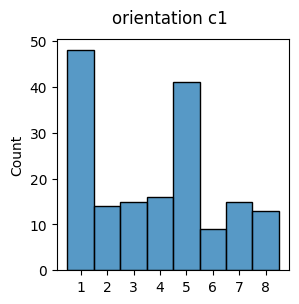

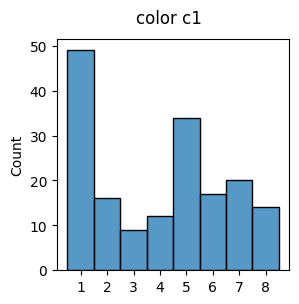

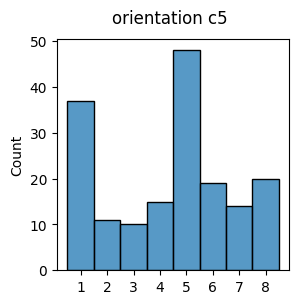

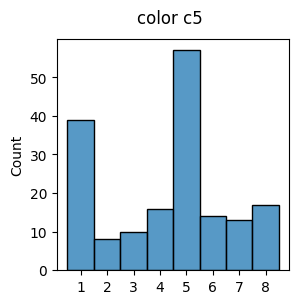

In [166]:
for task_o_c,o_c in zip([task_o1,task_o5,task_c1,task_c5],['o1','o5','c1','c5']):
    test_stimuli,code_numbers,code_samples,sp_samples = select_trials(bhv,data,trial_idx[task_o_c['trial_idx'].values],i_neuron=0)
    code = task_o_c['code'].values
    test_stimuli_samp = delete_match(test_stimuli,code)
    test_stimuli_samp = test_stimuli_samp[np.nansum(sp_samples,axis=1)>0]
    # orientation
    test_stimuli_o = (test_stimuli_samp//10)
    # test_o = pd.DataFrame(test_stimuli_o).replace([1,2,3,4,5,6,7,8,np.nan],['o1','o2','o3','o4','o5','o6','o7','o8','nan'])
    fig,ax = plt.subplots(figsize=(3,3))
    sns.histplot(np.sort(test_stimuli_o[np.where(np.isnan(test_stimuli_o),False,True)]).astype(int).astype(str))
    fig.suptitle('orientation %s' %o_c)
    # color
    test_stimuli_o = (test_stimuli_samp%10)
    # test_o = pd.DataFrame(test_stimuli_o).replace([1,2,3,4,5,6,7,8,np.nan],['c1','c2','c3','c4','c5','c6','c7','c8','nan'])
    fig,ax = plt.subplots(figsize=(3,3))
    sns.histplot(np.sort(test_stimuli_o[np.where(np.isnan(test_stimuli_o),False,True)]).astype(int).astype(str))
    fig.suptitle('color %s'%o_c)